# 0. Introduction

This notebook compares the performance of two models:
1. Random Forest
2. Neural Network (2 Dense layers/3 Dense layers/3 Dense layers + L2 norm)

...on the prediction of aggregated median house prices in Californian neighborhoods. Predictors include coordinates of neighborhoods, proximity to the ocean, and several aggregated house/population properties. The dataset is publicly available here:
https://www.kaggle.com/camnugent/california-housing-prices

In [ ]:
# Import packages

In [1]:
# Tensorflow/pandas/np
import tensorflow as tf
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.externals import joblib

# Geopandas for GIS data IO
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Pyplot and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# 1. Data prep/cleaning

Overall, the data seems very clean. There are only ~1% missings in total_bedrooms column. We will use an imputer to deal with this column in the pipeline of sklearn.

In [3]:
# Read/describe data
data_prices = pd.read_csv('data_source/housing.csv')

In [4]:
data_prices.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41,21,52,52,52
total_rooms,880,7099,1467,1274,1627
total_bedrooms,129,1106,190,235,280
population,322,2401,496,558,565
households,126,1138,177,219,259
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600,358500,352100,341300,342200
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [21]:
# Info - only one column with missings, 1 string column
data_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dist_la               20640 non-null float64
dist_sf               20640 non-null float64
bedrooms_missing      20640 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 2.0+ MB


In [6]:
# Min/max values seem ok, so do means/medians and standard deviations. Nothing too crazy.
data_prices.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


# 2. Data exploration

1. As could be expected, the most expensive houses are in the Bay Area and Los Angeles. Sacramento area seems densely populated as well, but not that expensive. 
2. Not all areas near the ocean are expensive.
3. Perhaps a good idea would be to create distances to SF/LA as predictors, based on points 1 and 2.
4. There seems to be only weak linear associations of predictors with house price. Most likely due to being aggregated to neighborhoods. Median income seems to be a good linear predictor.
5. Population does not reflect price (!), so it does not really capture density. Since we have no better proxies for that, coordinates and distance to SF/LA will have to do the job.

## Geographic distribution

In [25]:
# Read in shapefile of US state boundaries
state_shapes = gpd.read_file('geo_data/states.shp')
state_shapes.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


In [0]:
# Select Cali
cali_shape = state_shapes.loc[state_shapes["STATE_NAME"]=="California",]

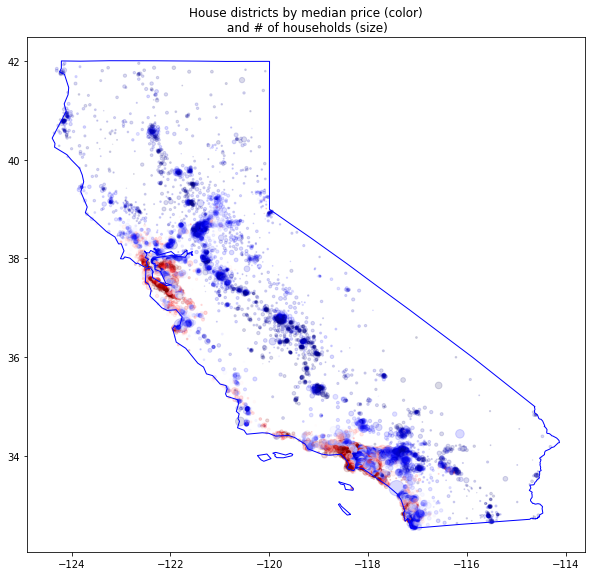

In [27]:
# Plot median prices by geography and number of households
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=data_prices.longitude, y=data_prices.latitude, 
             s=(data_prices.population/data_prices.households.max())*40,
            c=data_prices.median_house_value, cmap='seismic', alpha=0.15)
plt.title("House districts by median price (color)\n and # of households (size)")
cali_shape.plot(ax=ax, edgecolor="blue", facecolor=(0,0,0,0))
plt.show()

## Linear associations

In [41]:
# Create quartile groupby's for main predictors in a new dataframe for barcharts
data_bar = data_prices.copy()

data_bar.sort_values("housing_median_age", inplace=True)
data_bar["age_quantiles"] = pd.qcut(data_bar.housing_median_age, 5)

data_bar.sort_values("total_rooms", inplace=True)
data_bar["room_quantiles"] = pd.qcut(data_bar.total_rooms, 5)

data_bar.sort_values("median_income", inplace=True)
data_bar["income_quantiles"] = pd.qcut(data_bar.median_income, 5)

data_bar.sort_values("population", inplace=True)
data_bar["pop_quantiles"] = pd.qcut(data_bar.population, 5)

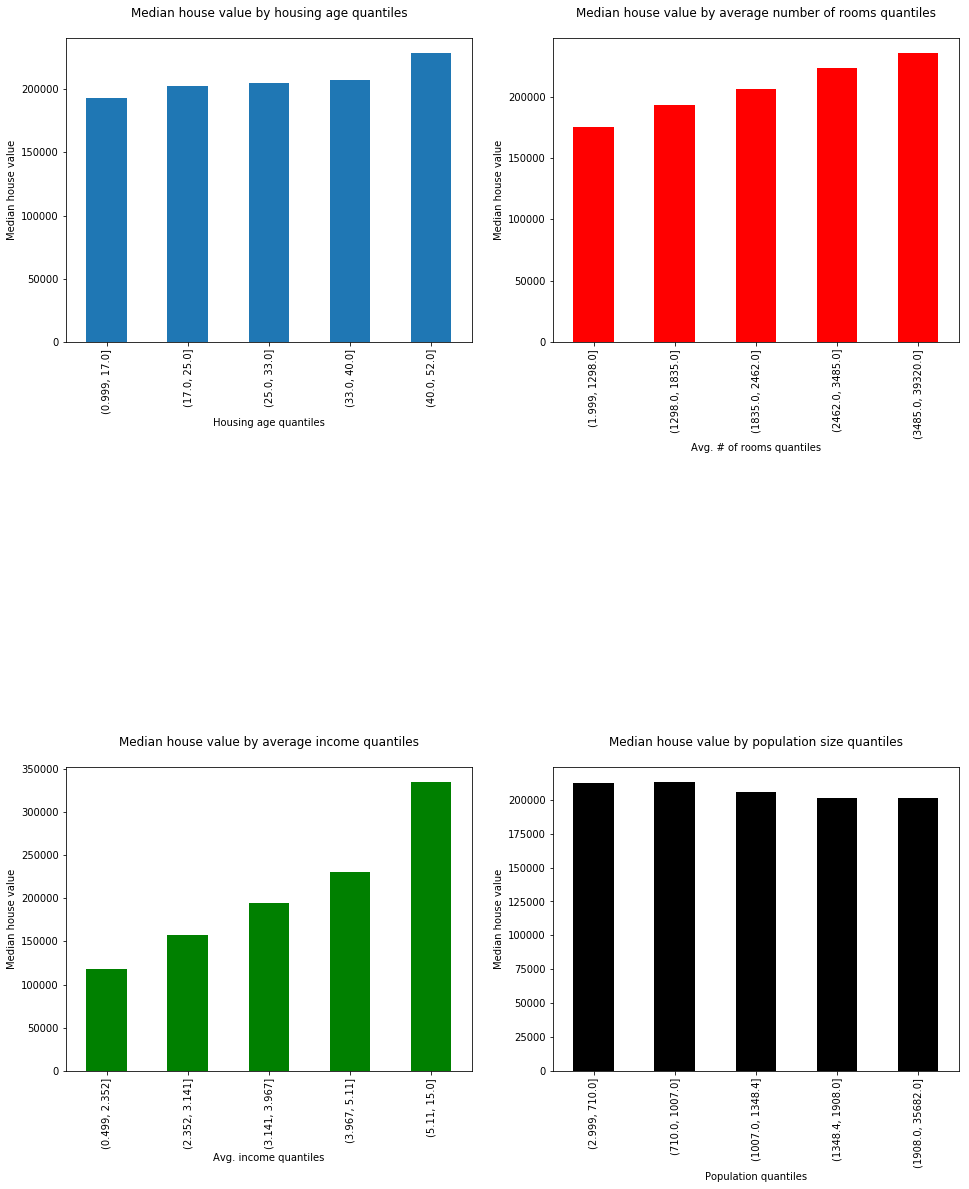

In [64]:
# Create plots (skip 2 in the middle to prevent label overlap)
plt.figure(figsize=(16,19))

plt.subplot(3,2,1)
data_bar.groupby("age_quantiles").median_house_value.mean().plot(kind="bar")
plt.title("Median house value by housing age quantiles\n")
plt.xlabel("Housing age quantiles")
plt.ylabel("Median house value")

plt.subplot(3,2,2)
data_bar.groupby("room_quantiles").median_house_value.mean().plot(kind="bar", color="red")
plt.title("Median house value by average number of rooms quantiles\n")
plt.xlabel("Avg. # of rooms quantiles")
plt.ylabel("Median house value")

plt.subplot(3,2,5)
data_bar.groupby("income_quantiles").median_house_value.mean().plot(kind="bar", color="green")
plt.title("Median house value by average income quantiles\n")
plt.xlabel("Avg. income quantiles")
plt.ylabel("Median house value")

plt.subplot(3,2,6)
data_bar.groupby("pop_quantiles").median_house_value.mean().plot(kind="bar", color="black")
plt.title("Median house value by population size quantiles\n")
plt.xlabel("Population quantiles")
plt.ylabel("Median house value")


plt.show()

# 3. Feature engineering

1. Create distance of each coordinate to San Francisco and L.A. (coordinates for these places based on Google Maps pin when searching these places, approx downtown areas). Seems to have no linear relationships with the outcome, but should work well as an interaction.
2. Create binary column for missings in total_bedrooms column

In [7]:
# Create DF with LA/SF coordinates
cities = pd.DataFrame({"city": ["LA", "SF"], "longitude": [-118.290582, -122.429685],
                      "latitude": [34.040103, 37.774755]})

# Import math funs for coordinate distance calculation

from math import sin, cos, sqrt, atan2, radians

# Function for calculating distances between 2 points
# Borrowed from: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
def dist_coords(lon1, lat1, lon2, lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6373.0
    distance = R * c

    return distance

# Create distances as data_prices predictors 
distance_la = data_prices.apply(lambda x: dist_coords(x["longitude"], x["latitude"],
                                                     cities.loc[cities["city"]=="LA", "longitude"],
                                                     cities.loc[cities["city"]=="LA", "latitude"]),axis=1)
distance_sf = data_prices.apply(lambda x: dist_coords(x["longitude"], x["latitude"],
                                                     cities.loc[cities["city"]=="SF", "longitude"],
                                                     cities.loc[cities["city"]=="SF", "latitude"]),axis=1)
data_prices["dist_la"] = distance_la
data_prices["dist_sf"] = distance_sf

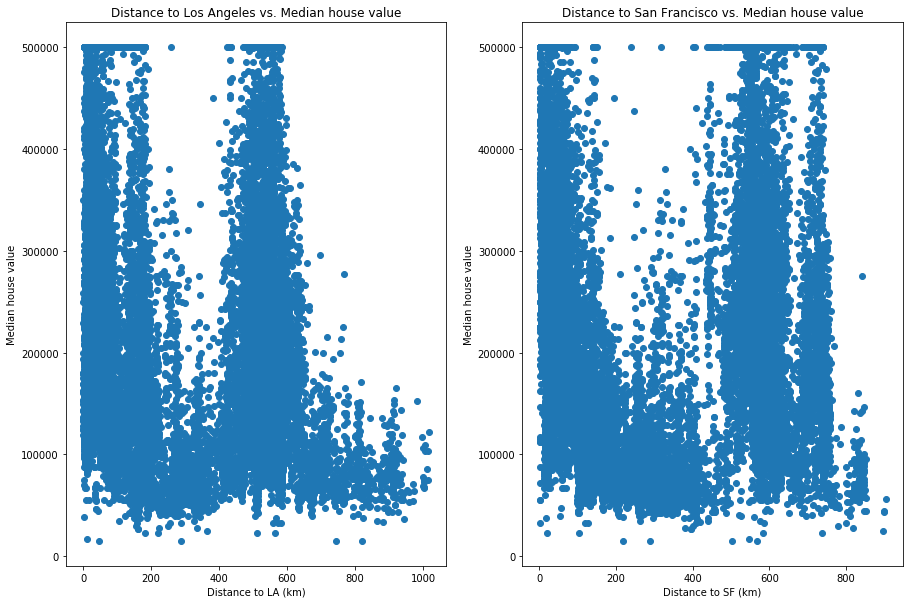

In [72]:
# Plot to see
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.scatter(data_prices.dist_la, data_prices.median_house_value)
plt.title("Distance to Los Angeles vs. Median house value")
plt.xlabel("Distance to LA (km)")
plt.ylabel("Median house value")

plt.subplot(1,2,2)
plt.scatter(data_prices.dist_sf, data_prices.median_house_value)
plt.title("Distance to San Francisco vs. Median house value")
plt.xlabel("Distance to SF (km)")
plt.ylabel("Median house value")

plt.show()

In [74]:
# Make column for missing bedrooms
data_prices["bedrooms_missing"] = 0
data_prices.loc[data_prices["total_bedrooms"].isna(), "bedrooms_missing"] = 1
print("Number of missings in total_bedrooms:\n", data_prices.bedrooms_missing.value_counts())

Number of missings in total_bedrooms:
 0    20433
1      207
Name: bedrooms_missing, dtype: int64


# 4.1 Random forests

80/20 split used, OneHotEncoding for the categorical variable and StandardScaler for numerical ones in the pipeline. Missings imputed with median of the column.

Two RF models are fit:
1. Naive RF with default settings 
2. Final RF model after RandomizedSearchCV and final tuning with GridSearch

In [9]:
# Get different objects for predictors/outcomes
data_preds = data_prices[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'bedrooms_missing', 'population', 'households', 'median_income', 
       'dist_la', 'dist_sf', 'ocean_proximity']]

data_outcomes = data_prices['median_house_value']


# Do the train test split (80/20)
train_preds, test_preds, train_outcomes, test_outcomes = train_test_split(data_preds, data_outcomes,
                                                                         test_size=0.2)

In [11]:
# Save the train/test datasets to files
[i.to_csv("train_test_data/"+ j +".csv", header=True) for i,j in zip([train_preds, train_outcomes, 
                                                                    test_preds, test_outcomes],
                                                                  ["train_preds", "train_outcomes", 
                                                                   "test_preds", "test_outcomes"])]

[None, None, None, None]

In [12]:
# Set the pipeline

# Features
numeric_features = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'bedrooms_missing', 'longitude', 'latitude', 'dist_la', 'dist_sf']
categorical_features = ['ocean_proximity']

# Column transformation
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='median')),
     ('standardscaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder()),
])

# Set preprocessor
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features),
])

# Final pipeline = column preprocessor + model
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(n_jobs=-1, verbose=True))
])

In [13]:
# Make scorer
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=False)

### Naive RF with defaults

In [78]:
# Create dataframes specifically for this model, don't use the pipeline (separate datasets)
# Encoders
ohe = OneHotEncoder(sparse=False)
ssc = StandardScaler()

# Transform columns and fill missings
def df_transformer(dset):
    dset[numeric_features] = ssc.fit_transform(dset[numeric_features])
    ohe_trans = pd.get_dummies(dset[categorical_features])
    return pd.concat([dset.iloc[:,:11], ohe_trans], axis=1) 

baseline_train = train_preds.copy()
baseline_train = df_transformer(baseline_train)
baseline_train.loc[baseline_train["total_bedrooms"].isna(), "total_bedrooms"] = \
                                                        baseline_train.total_bedrooms.median()

baseline_test = test_preds.copy()
baseline_test = df_transformer(baseline_test)
baseline_test.loc[baseline_test["total_bedrooms"].isna(), "total_bedrooms"] = \
                                                        baseline_test.total_bedrooms.median()


# Fit the model
rf_baseline = RandomForestRegressor(n_jobs=-1)
rf_baseline.fit(baseline_train, train_outcomes)

# Predictions
predictions = rf_baseline.predict(baseline_train)
test_predictions = rf_baseline.predict(baseline_test)
print("*** NAIVE RF MODEL RESULTS (RMSE) ***")
print("Train: ", np.sqrt(mean_squared_error(train_outcomes, predictions)))
print("Test: ", np.sqrt(mean_squared_error(test_outcomes, test_predictions)))

/home/lukas/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/lukas/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/lukas/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/lukas/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/lukas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The defaul

*** NAIVE RF MODEL RESULTS (RMSE) ***
Train:  21097.285240660174
Test:  54907.65312661997


In [ ]:
# Create parameter grid for RF initial randomized search
params = {
    "rf__max_features": np.arange(2,len(train_preds.columns)),
    "rf__n_estimators": np.linspace(10,50,20).astype(np.int),
    "rf__min_samples_split": np.linspace(1e-4,1e-2,100),
    "rf__min_samples_leaf": np.linspace(1e-4,1e-2,100),
    "rf__max_depth": np.arange(2,32)
}

In [17]:
grid = RandomizedSearchCV(rf_pipeline, 
                          param_distributions=params,
                          n_iter=250, cv=5, 
                          verbose=5, n_jobs=-1,
                          scoring=mean_squared_error_scorer, refit=True)

In [18]:
grid.fit(train_preds, train_outcomes)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 10.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    2.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', v...jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False))]),
          fit_params=None, iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'rf__max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'rf__n_estimators': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 31, 33, 35, 37, 39, 41, 43,
       45, 47, 50]), 'rf__min_samples_split': array([0.0001, 0.0002, ..., 0.0099, 0.01  ]), 'rf__min_samples_leaf': array([0.0001, 0.0002, ..., 0.0099, 0.01  ]), 'rf__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13

In [76]:
# Get best estimator
grid.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('numeric', Pipeline(memory=None,
       steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
         strategy='median', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['housing_median_age', 'total_rooms', 'total_be...umpy.float64'>, handle_unknown='error',
         n_values=None, sparse=True))]), ['ocean_proximity'])])),
 ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
             max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=0.0008,
             min_samples_split=0.0015, min_weight_fraction_leaf=0.0,
             n_estimators=43, n_jobs=-1, oob_score=False, random_state=None,
             verbose=True, warm_start=False))]

In [79]:
# Predict initial results
predictions = grid.predict(train_preds)
test_predictions = grid.predict(test_preds)

print("*** RESULTS AFTER INITIAL SEARCH (RMSE)***")
print("Train: ", np.sqrt(mean_squared_error(train_outcomes, predictions)))
print("Test: ", np.sqrt(mean_squared_error(test_outcomes, test_predictions)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  43 out of  43 | elapsed:    0.0s finished


*** RESULTS AFTER INITIAL SEARCH (RMSE)***
Train:  43151.98987713037
Test:  50354.981350767805


### Interrim conclusions

After initial randomized search already, seems like the RF model with tuned parameters overfits less - worse on Train data, but better on Test data by roughly 5000$. Parameters will now be further fine-tuned with gridsearch, around the best parameters of randomized search.

In [80]:
# Finetune parameters with gridsearch and more estimators
parameter_grid = {
    "rf__max_depth": [27, 28, 29],
    "rf__min_samples_leaf": [7e-4, 8e-4, 9e-4],
    "rf__max_features": [7, 8, 9],
    "rf__min_samples_split": [12e-4, 15e-4, 18e-4],
    "rf__n_estimators": [200],
}

grid_2 = GridSearchCV(rf_pipeline, param_grid=parameter_grid,
                    cv=5, verbose=5, n_jobs=-1,
                    scoring=mean_squared_error_scorer, refit=True)

In [81]:
# Fit the fine_tuned model
grid_2.fit(train_preds, train_outcomes)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 26.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', v...jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rf__max_depth': [27, 28, 29], 'rf__min_samples_leaf': [0.0007, 0.0008, 0.0009], 'rf__max_features': [7, 8, 9], 'rf__min_samples_split': [0.0012, 0.0015, 0.0018], 'rf__n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=5)

In [84]:
# Get the final estimator
grid_2.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
           transformer_weights=None,
           transformers=[('numeric', Pipeline(memory=None,
       steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
         strategy='median', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['housing_median_age', 'total_rooms', 'total_be...umpy.float64'>, handle_unknown='error',
         n_values=None, sparse=True))]), ['ocean_proximity'])])),
 ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
             max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=0.0007,
             min_samples_split=0.0012, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
             verbose=True, warm_start=False))]

In [85]:
# Make the final predictions
predictions = grid_2.predict(train_preds)
test_predictions = grid_2.predict(test_preds)

print("*** FINAL RF MODEL ***")
print("Train: ", np.sqrt(mean_squared_error(train_outcomes, predictions)))
print("Test: ", np.sqrt(mean_squared_error(test_outcomes, test_predictions)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


*** FINAL RF MODEL ***
Train:  41920.475933606576
Test:  49715.62696875053


In [87]:
# Save final model
final_model = grid_2.best_estimator_
joblib.dump(final_model, 'models/rf_final.pkl')

['models/rf_final.pkl']

## 4.1.1 Get some insights into RF predictions

1. Main predictors are geography and income, as expected.
2. The distribution of errors shows that they might be up to -200000 or 300000, although for very few cases. 
3. There are no clear geographical patterns, although it seems that some cases within cities are not well prediced. 

Conclusion: to get better predictions without more data, it would be possible to get some aggregate level SF/LA neighborhood data, like crime, facilities around, noise, etc. This should be publicly available and might get us better predictions on price variation between different areas of cities

In [93]:
# Get errors
train_errors = train_preds.copy()
train_errors["errors"] = train_outcomes-predictions

### Error distribution

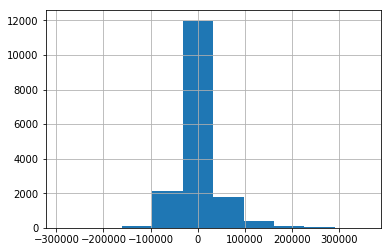

In [94]:
train_errors.errors.hist()

### Geographical distribution of errors

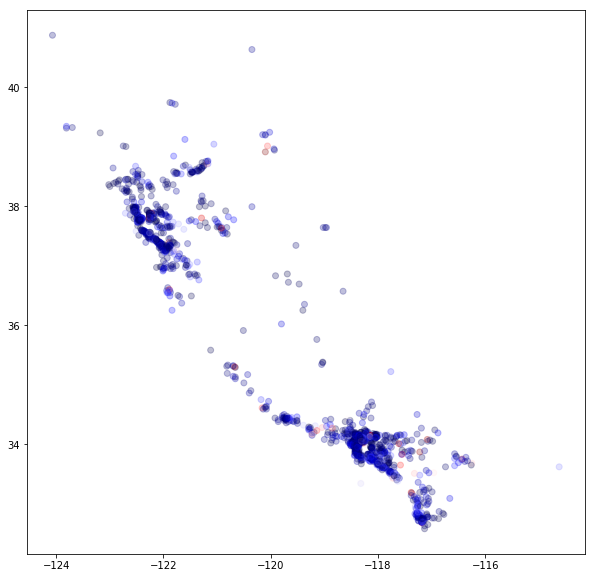

In [99]:
# Plot same map as before, but with errors

train_errors_reduced = train_errors.loc[train_errors["errors"] > 50000, :]
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=train_errors_reduced.longitude, y=train_errors_reduced.latitude, 
             c=train_errors_reduced.errors, cmap='seismic', alpha=0.25)
plt.show()

In [0]:
# Define a function for feature importances:
# 1. shuffles columns one-by-one,
# 2. re-predicts the model
# 3. calculates difference in RMSE to original data
# 4. takes the differences and normalizes them to get importances (= importances add to 1)

def feature_importance(model):
    importances = {}
    for i in train_preds.columns:
        train_data_cp = train_preds.copy().reset_index(drop=True)
        train_data_cp[i] = train_data_cp[i].sample(frac=1).reset_index(drop=True)
        predictions = model.predict(train_data_cp)
        rmse_score = np.sqrt(mean_squared_error(np.array(train_outcomes), predictions))
        importances[i] = rmse_score - 34792.13474475985
    
    sum_importances = sum(importances.values())
    for i,j in importances.items():
        importances[i] = j / sum_importances
        
    return importances
        
# Get importances
feat_imps = feature_importance(final_model)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      |

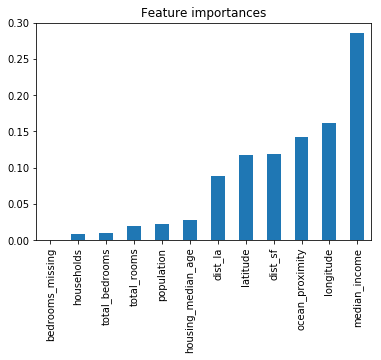

In [0]:
# Plot importances
pd.DataFrame(feat_imps, index=["importance"]).T.sort_values("importance").plot(kind="bar", sort_columns=True,
                                                                               legend=False, 
                                                                                title="Feature importances")

# 4.2 Neural nets

Separate train/validation/test splits are made: ~0.65/0.15/0.2. Numeric features scaled with StandardScaler, categorical OneHotEncoded. Three models estimated:

1. 2 dense layers
2. 3 dense layers
3. 3 dense layers + L1 regularization

### Data pre-processing and train/validation/test split

In [14]:
# Impute train/test data and split to additional train/validation
train_preds[train_preds.total_bedrooms.isna()] = train_preds.total_bedrooms.median()
test_preds[test_preds.total_bedrooms.isna()] = test_preds.total_bedrooms.median()


# Do the train/test split
nn_train_preds, nn_validation_preds, nn_train_outcomes, nn_validation_outcomes = \
                    train_test_split(train_preds, train_outcomes, test_size=0.2)

nn_test_preds = test_preds.copy()
nn_test_outcomes = test_outcomes.copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [15]:
# Normalize and onehot encode data using the function defined earlier
numeric_features = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'bedrooms_missing', 'longitude', 'latitude', 'dist_la', 'dist_sf']
categorical_features = ['ocean_proximity']  

nn_train_preds = df_transformer(nn_train_preds)
nn_test_preds = df_transformer(nn_test_preds)
nn_validation_preds = df_transformer(nn_validation_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [16]:
# During one-hot encoded 'Island' category was not available in validation/test, since very few cases exist
# Set these to zero in validation/test data.
print(nn_test_preds.columns, nn_validation_preds.columns)

nn_test_preds["ocean_proximity_ISLAND"] = 0
nn_validation_preds["ocean_proximity_ISLAND"] = 0

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'bedrooms_missing', 'population', 'households',
       'median_income', 'dist_la', 'dist_sf', 'ocean_proximity_426.0',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object') Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'bedrooms_missing', 'population', 'households',
       'median_income', 'dist_la', 'dist_sf', 'ocean_proximity_437.0',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')


### NN 1 

In [0]:
# Set constants
LR = 1e-3
N_EPOCHS = 150
BATCH_SIZE = 64

In [0]:
# Make a function that creates the network structure
# Batch normalization in each layer
# Dense layers, he_uniform weight initializer
# LeakyReLU in each layer
# Final layer = Dense
def price_regressor(n_layers, layer_size, n_classes, input_shape):
    layers = [tf.keras.layers.BatchNormalization(input_shape=input_shape)]
    for i in range(n_layers):
    layers.extend([
        tf.keras.layers.Dense(layer_size, kernel_initializer='he_uniform'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.BatchNormalization(),
    ])
    layers.append(tf.keras.layers.Dense(1))
    return tf.keras.Sequential(layers)

In [0]:
# Compile NN 1 with 2 layers, RMSprop optimizer and MSE loss function
price_nnr = price_regressor(n_layers=2, layer_size=32, n_classes=1,
                      input_shape=nn_train_preds.values.shape[1:])

price_nnr.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
    ]
)

In [0]:
# Fit NN 1
price_nnr.fit(
    x=nn_train_preds.values,
    y=nn_train_outcomes.values,
    validation_data=(nn_validation_preds.values, nn_validation_outcomes.values),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
)

In [0]:
# Save the model
price_nnr.save('models/price_nnr_1.h5')
price_nnr_loaded = tf.keras.models.load_model("models/price_nnr_1.h5")

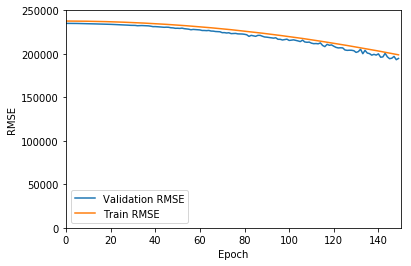

In [0]:
# Plot the train/validation RMSE
price_nnr_history = pd.DataFrame(price_nnr.history.history)

sns.lineplot(x=price_nnr_history.val_loss.index, 
         y=np.sqrt(price_nnr_history.val_mean_squared_error), 
         label="Validation RMSE")

sns.lineplot(x=price_nnr_history.val_loss.index, 
         y=np.sqrt(price_nnr_history.mean_squared_error), 
         label="Train RMSE")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.ylim(0,250000)
plt.xlim(0,150)

plt.show()

##### Seems like we need more epochs, since RMSE is continuously dropping, but is still very high. Let's also try to add one more layer of Dense.

### NN2

In [0]:
# Increase number of epochs to 500 and layers to 3
N_EPOCHS = 500

price_nnr_2 = price_regressor(n_layers=3, layer_size=32, n_classes=1,
                      input_shape=nn_train_preds.values.shape[1:])

# Compile
price_nnr_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
    ]
)

# Fit
price_nnr_2.fit(
    x=nn_train_preds.values,
    y=nn_train_outcomes.values,
    validation_data=(nn_validation_preds.values, nn_validation_outcomes.values),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
)

In [0]:
# Save the model
price_nnr_2.save('models/price_nnr_2.h5')
price_nnr_2_loaded = tf.keras.models.load_model("models/price_nnr_2.h5")

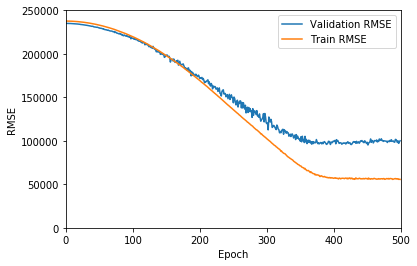

In [0]:
# Visualize train/validation RMSE
price_nnr_2_history = pd.DataFrame(price_nnr_2.history.history)

sns.lineplot(x=price_nnr_2_history.val_loss.index, 
         y=np.sqrt(price_nnr_2_history.val_mean_squared_error), 
         label="Validation RMSE")

sns.lineplot(x=price_nnr_2_history.val_loss.index, 
         y=np.sqrt(price_nnr_2_history.mean_squared_error), 
         label="Train RMSE")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.ylim(0,250000)
plt.xlim(0,500)

plt.show()

##### This is clearly better, but we the model still starts overfitting relatively early. Let's try adding some regularization. 

### NN 3

In [0]:
# Re-define the function with L1 regularizer
def price_regressor(n_layers, layer_size, n_classes, input_shape, l1_alpha):
    layers = [tf.keras.layers.BatchNormalization(input_shape=input_shape)]
    for i in range(n_layers):
    layers.extend([
        tf.keras.layers.Dense(layer_size, kernel_initializer='he_uniform',
                             kernel_regularizer=tf.keras.regularizers.l1(l1_alpha)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.BatchNormalization(),
    ])
    layers.append(tf.keras.layers.Dense(1))
    return tf.keras.Sequential(layers)

In [0]:
# Initialize and compile the network with 3 layers and 1e-3 L1 alpha 
price_nnr_3 = price_regressor(n_layers=3, layer_size=32, n_classes=1,
                      input_shape=nn_train_preds.values.shape[1:],
                             l1_alpha=1e-3)

# Compile
price_nnr_3.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
    loss=tf.keras.losses.mean_squared_error,
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
    ]
)

# Fit
price_nnr_3.fit(
    x=nn_train_preds.values,
    y=nn_train_outcomes.values,
    validation_data=(nn_validation_preds.values, nn_validation_outcomes.values),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
)

In [0]:
# Save
price_nnr_3.save('models/price_nnr_3.h5')
price_nnr_3_loaded = tf.keras.models.load_model("models/price_nnr_3.h5")

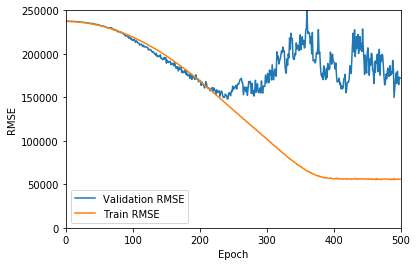

In [43]:
# Plot train/validation RMSE
price_nnr_3_history = pd.DataFrame(price_nnr_3.history.history)

sns.lineplot(x=price_nnr_3_history.val_loss.index, 
         y=np.sqrt(price_nnr_3_history.val_mean_squared_error), 
         label="Validation RMSE")

sns.lineplot(x=price_nnr_3_history.val_loss.index, 
         y=np.sqrt(price_nnr_3_history.mean_squared_error), 
         label="Train RMSE")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.ylim(0,250000)
plt.xlim(0,500)

plt.show()

##### Interrim conclusions - we should play around more with regularization/different architectures of the network. This model started grossly overfitting relatively early at around similar RMSE.

In [0]:
# Make predictions of NNs
predictions_nnr_1 = price_nnr_loaded.predict(nn_test_preds)
predictions_nnr_2 = price_nnr_2_loaded.predict(nn_test_preds)
predictions_nnr_3 = price_nnr_3.predict(nn_test_preds)

In [89]:
# Make predictions of RF naive and final models
predictions_rf_1 = rf_baseline.predict(baseline_test)
predictions_rf_2 = final_model.predict(test_preds)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [91]:
# Store test scores
rmse_nnr_1 = np.sqrt(mean_squared_error(nn_test_outcomes, predictions_nnr_1))
rmse_nnr_2 = np.sqrt(mean_squared_error(nn_test_outcomes, predictions_nnr_2))
rmse_nnr_3 = np.sqrt(mean_squared_error(nn_test_outcomes, predictions_nnr_3))
rmse_rf_1 = np.sqrt(mean_squared_error(test_outcomes, predictions_rf_1))
rmse_rf_2 = np.sqrt(mean_squared_error(test_outcomes, predictions_rf_2))

205652.3715219814 88263.91881561244 87931.38644197005 54907.65312661997 49715.62696875053


In [92]:
# Make final comparison
comparison = pd.DataFrame({"Model": ["NN_2layer", "NN_3layer", "NN_3layer_L1_reg", "RF_naive", "RF_final"],
                          "RMSE": [rmse_nnr_1, rmse_nnr_2, rmse_nnr_3, rmse_rf_1, rmse_rf_2]})

comparison

,Model,RMSE
0,NN_2layer,205652.371522
1,NN_3layer,88263.918816
2,NN_3layer_L1_reg,87931.386442
3,RF_naive,54907.653127
4,RF_final,49715.626969


# 5. Conclusion

With my current knowledge and timeframe of creating these NNs, they underperform against RF's. Likely because the latter efficiently splits geographical locations. Even more likely, because the current NN models were underspecified. 

TODO:
1. Work with different network structures/rates/regularizations/etc. 
2. Try out geohashing for neural nets.